<a href="https://colab.research.google.com/github/kyunap/deepcad/blob/main/DeepCAD_RT_pytorch/notebooks/DeepCAD_RT_demo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A cloud-based demo for DeepCAD-RT**
<img src="https://github.com/cabooster/DeepCAD-RT/blob/page/images/logo.PNG?raw=true" width = "650" height = "180" align=right />


This file will demonstrate the basic pipeline for training and testing DeepCAD-RT. A TIFF file will be downloaded automatically to be the example data. More information about the method and relevant results can be found in the companion paper：

**Real-time denoising of fluorescence time-lapse imaging enables high-sensitivity observations of biological dynamics beyond the shot-noise limit. bioRxiv (2022).**

---

## <font color=#FF8247>**1. Initialization**</font>

Install DeepCAD-RT (the GPU version of Pytorch will be installed on cloud server)

In [1]:
!pip install deepcad

## <font color=#FF8247>**2. Check GPU support**</font>

In [2]:


import torch

if torch.cuda.is_available():
    print('\033[1;31mGPU accessiable. Use GPU for computation.\033[0m')
    gpu_id = torch.cuda.current_device()
    total_memory = torch.cuda.get_device_properties(gpu_id).total_memory/1024/1024
    alloc_memory = torch.cuda.memory_allocated(0)/1024/1024
    print('GPU ID: ', gpu_id, '|', torch.cuda.get_device_name(), \
          '| Memory: {:.0f} MB'.format(total_memory))
    ! nvcc --version
    print('PyTorch version: ', torch.__version__)
else:
    print('\033[1;31mNo GPU support. Please enable GPUs for the notebook:\033[0m')
    print(' 1. Navigate to Edit → Notebook Settings')
    print(' 2. Select GPU from the Hardware Accelerator drop-down')

GPU accessiable. Use GPU for computation.
GPU ID:  0 | Tesla T4 | Memory: 15095 MB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
PyTorch version:  2.6.0+cu124


## <font color=#FF8247>**Option 1: The training pipeline**</font>

In [3]:
!git clone https://github.com/cabooster/DeepCAD-RT
%cd DeepCAD-RT/DeepCAD_RT_pytorch/

fatal: destination path 'DeepCAD-RT' already exists and is not an empty directory.
/content/DeepCAD-RT/DeepCAD_RT_pytorch


In [4]:
!pip install csbdeep
from deepcad.train_collection import training_class
from deepcad.movie_display import display, display_img
from deepcad.utils import get_first_filename, download_demo

### Select file(s) to be processed (download if not present)


*  The `download_demo` function will download demo files (example data and a pre-trained model) and return the full paths of them. The data will be saved in /content/datasets and the model will be saved in /content/pth.

*   If you want to use your own data or model, please replace them with your own files.

In [5]:
download_demo_file = True
if download_demo_file:
    file_name='fish_localbrain' # select the demo file you want to train (e.g. 'ATP_3D', 'fish_localbrain', 'NP_3D', ...)
    datasets_path, _ =download_demo(download_filename=file_name)
else:
    datasets_path = 'datasets/fish_localbrain_demo'  # folder containing files for training

### Show the input low-SNR data (optional)

One frame of the input video is shown (optional). This is not an indispensable step.

Displaying the first raw file -----> 
datasets/fish_localbrain_demo/fish_localbrain.tif


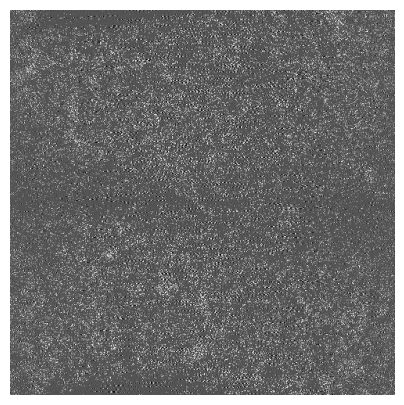

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5,5)
display_images = True

if display_images:
    display_filename = get_first_filename(datasets_path)
    print('\033[1;31mDisplaying the first raw file -----> \033[0m')
    print(display_filename)
    # normalize the image and display
    img = display_img(display_filename,norm_min_percent=1, norm_max_percent=99)
    plt.imshow(img,cmap=plt.cm.gray,vmin=0,vmax=255)
    plt.axis('off')
    plt.show()

### Set the parameters for training
Default setting shows the parameters for the demo file, which are also appropriate for most data. You can change these parameters according to your data and device.

**Notice**: This is a very shot training. We just set `n_epochs=2` and `train_data_sizes=2000` because Google Colab have an idle timeout of 90 minutes and an absolute timeout of 12 hours. This means, if user does not interact with his Colab notebook for more than 90 minutes, its instance will be terminated automatically. We suggest increasing `n_epochs` and `train_data_sizes` for better performance. The result of the optimal model (`n_epochs=5`, `train_data_sizes=6000`) is shown in the testing pipeline.

In [7]:
n_epochs = 2                # number of training epochs
GPU = '0'                   # the index of GPU you will use (e.g. '0', '0,1', '0,1,2')
train_datasets_size = 2000  # datasets size for training (how many 3D patches)
patch_xyt = 150             # the width, height, and length of 3D patches (use isotropic patch size by default)
overlap_factor = 0.4        # the overlap factor between two adjacent patches
num_workers = 0             # if you use Windows system, set this to 0.

# Setup some parameters for result visualization during training period (optional)
save_test_images_per_epoch = True  # whether to save result images after each epoch

### Create a training object with specified parameters
This will creat a training object by passing all parameters as a dictionary. Parameters not specified in the dictionary will use default values.

In [8]:
train_dict = {
    # dataset dependent parameters
    'patch_x': patch_xyt,                          # the width of 3D patches
    'patch_y': patch_xyt,                          # the height of 3D patches
    'patch_t': patch_xyt,                          # the time dimension (frames) of 3D patches
    'overlap_factor':overlap_factor,               # the factor for image intensity scaling
    'scale_factor': 1,                             # the factor for image intensity scaling
    'select_img_num': 2000,                        # select the number of images used for training (use 2000 frames in colab)
    'train_datasets_size': train_datasets_size,    # datasets size for training (how many 3D patches)
    'datasets_path': datasets_path,                # folder containing files for training
    'pth_dir': './pth',                            # the path for pth file and result images

    # network related parameters
    'n_epochs': n_epochs,                          # the number of training epochs
    'lr': 0.00005,                                 # learning rate
    'b1': 0.5,                                     # Adam: bata1
    'b2': 0.999,                                   # Adam: bata2
    'fmap': 16,                                    # model complexity
    'GPU': GPU,                                    # GPU index
    'num_workers': num_workers,                    # if you use Windows system, set this to 0.
    'visualize_images_per_epoch': False,                       # whether to show result images after each epoch
    'save_test_images_per_epoch': save_test_images_per_epoch,  # whether to save result images after each epoch
    'colab_display': True
}
tc = training_class(train_dict)

Training parameters -----> 
{'overlap_factor': 0.4, 'datasets_path': 'datasets/fish_localbrain_demo', 'n_epochs': 2, 'fmap': 16, 'output_dir': './results', 'pth_dir': './pth', 'onnx_dir': './onnx', 'batch_size': 1, 'patch_t': 150, 'patch_x': 150, 'patch_y': 150, 'gap_y': 90, 'gap_x': 90, 'gap_t': 90, 'lr': 5e-05, 'b1': 0.5, 'b2': 0.999, 'GPU': '0', 'ngpu': 1, 'num_workers': 0, 'scale_factor': 1, 'train_datasets_size': 2000, 'select_img_num': 2000, 'test_datasize': 400, 'visualize_images_per_epoch': False, 'save_test_images_per_epoch': True, 'colab_display': True, 'result_display': ''}


### Start training
The training models and results can be found in `/content/pth`.

Notice: Colab notebook needs much longer time to train and test because of the limited GPU performance offered by Colab. It takes ~800 seconds per epoch for training on GeForce RTX 3090 (Nvidia) using the same parameters.

In [9]:
import os
print(os.path.exists('/content/DeepCAD-RT/DeepCAD_RT_pytorch/fish_localbrain.tif'))

False


In [10]:
from google.colab import drive
drive.mount('/content/drive')
import tifffile
import numpy as np

correct_path = '/content/drive/MyDrive/fish_localbrain_demo/fish_localbrain.tif'
my_array = tifffile.imread(correct_path).astype(np.float32)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
tc.run()

NameError: name 'my_array' is not defined

### Show the output denoised data (optional)

One frame of the output video is shown (optional).

In [1]:
if display_images:
    display_filename = tc.result_display
    print('\033[1;31mDisplaying denoised file of the last epoch-----> \033[0m')
    print(display_filename)
    # normalize the image and display
    img = display_img(display_filename,norm_min_percent=1, norm_max_percent=99)
    plt.imshow(img,cmap=plt.cm.gray,vmin=0,vmax=255)
    plt.axis('off')
    plt.show()

NameError: name 'display_images' is not defined

## <font color=#FF8247>**Option 2: The testing pipeline**</font>

In [ ]:
from deepcad.test_collection import testing_class
from deepcad.movie_display import display, display_img
from deepcad.utils import get_first_filename, download_demo

### Select file(s) to be processed (download if not present)
*   The `download_demo` function will download demo files (example data and a pre-trained model) and return the full paths of them. The data will be saved in /content/datasets and the model will be saved in /content/pth.

*   If you want to use your own data or model, please replace them with your own files.




In [ ]:
download_demo_file = True
if download_demo_file:
    file_name='fish_localbrain' # select the demo file you want to test (e.g. 'ATP_3D', 'fish_localbrain', 'NP_3D', ...)
    datasets_path, denoise_model =download_demo(download_filename=file_name)
else:
    datasets_path = 'datasets/2RPN-1000'       # folder containing all files to be tested
    denoise_model = '2RPN_202112101128_ov_0.5' # A folder containing models to be tested

### Set the parameters for testing
Default setting shows the parameters suitable for the demo file. You can change these parameters accroding to your data and device.

In [ ]:
test_datasize = 300                   # the number of slices to be tested
GPU = '0'                             # the index of GPU you will use for computation (e.g. '0', '0,1', '0,1,2')
patch_xyt = 150                       # the width, height, length of 3D patches
overlap_factor = 0.6        # the overlap factor between two adjacent patches
# Since the receptive field of 3D-Unet is ~90, seamless stitching requires an overlap (patch_xyt*overlap_factor）of at least 90 pixels
num_workers = 2                       # if you use Windows system, set this to 0.

### Show the input low-SNR data (optional)

One frame of the input video is shown (optional). It is not an indispensable step

Displaying the first raw file -----> 
datasets/fish_localbrain_demo/fish_localbrain.tif


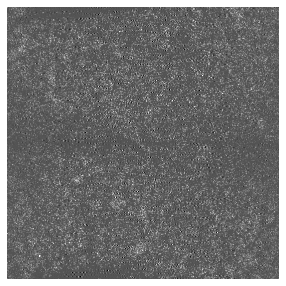

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (5,5)

display_images = True

if display_images:
    display_filename = get_first_filename(datasets_path)
    print('\033[1;31mDisplaying the first raw file -----> \033[0m')
    print(display_filename)
    # normalize the image and display
    img = display_img(display_filename,norm_min_percent=1, norm_max_percent=99)
    plt.imshow(img,cmap=plt.cm.gray,vmin=0,vmax=255)
    plt.axis('off')
    plt.show()

### Create a testing object with specified parameters
This will creat a testing object by passing all parameters as a dictionary. Parameters not specified in the dictionary will use their default values.

In [ ]:
test_dict = {
    # dataset dependent parameters
    'patch_x': patch_xyt,               # the width of 3D patches
    'patch_y': patch_xyt,               # the height of 3D patches
    'patch_t': patch_xyt,               # the time dimension (frames) of 3D patches
    'overlap_factor':overlap_factor,    # overlap factor
    'scale_factor': 1,                  # the factor for image intensity scaling
    'test_datasize': test_datasize,     # the number of frames to be tested
    'datasets_path': datasets_path,     # folder containing all files to be tested
    'pth_dir': './pth',                 # pth file root path
    'denoise_model' : denoise_model,    # A folder containing all models to be tested
    'output_dir' : './results',         # result file root path
    # network related parameters
    'fmap': 16,                         # number of feature maps
    'GPU': GPU,                         # GPU index
    'num_workers': num_workers,         # if you use Windows system, set this to 0.
    'visualize_images_per_epoch': False,# whether to display inference performance after each epoch
    'save_test_images_per_epoch': True, # whether to save inference image after each epoch in pth path
    'colab_display': True
}

tc = testing_class(test_dict)

Testing parameters -----> 
{'overlap_factor': 0.4, 'datasets_path': 'datasets/fish_localbrain_demo', 'fmap': 16, 'output_dir': './results', 'pth_dir': './pth', 'batch_size': 1, 'patch_t': 150, 'patch_x': 150, 'patch_y': 150, 'gap_y': 90, 'gap_x': 90, 'gap_t': 90, 'GPU': '0', 'ngpu': 1, 'num_workers': 2, 'scale_factor': 1, 'test_datasize': 300, 'denoise_model': 'fish_localbrain_best_model_demo', 'visualize_images_per_epoch': False, 'save_test_images_per_epoch': True, 'colab_display': True, 'result_display': ''}


### Start testing
Here we lanuch the testing process. All results will be in /content/results.

Notice: Colab notebook needs longer time to train and test because of the limited GPU performance offered by Colab. It takes ~8 seconds for testing on GeForce RTX 3090 (Nvidia) using the same parameters.

In [ ]:
tc.run()

Stacks for processing -----> 
Total stack number ----->  1
fish_localbrain.tif
Using 1 GPU(s) for testing -----> 
[Model 1/1, best_model.pth] [Stack 1/1, fish_localbrain.tif] [Patch 75/75] [Time Cost: 58 s] [ETA: 0 s]      
 Test finished. Save all results to disk.


### Show the output denoised data (optional)

One frame of the output video is shown (optional).

Displaying denoised file of the last epoch-----> 
./results//DataFolderIs_fish_localbrain_demo_202203160835_ModelFolderIs_fish_localbrain_best_model_demo//best_model//fish_localbrain_best_model_output.tif


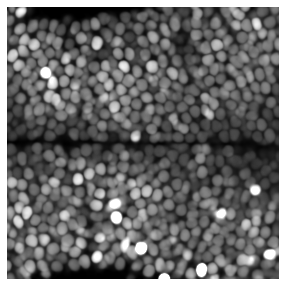

In [ ]:
if display_images:
    display_filename = tc.result_display
    print('\033[1;31mDisplaying denoised file of the last epoch-----> \033[0m')
    print(display_filename)
    # normalize the image and display
    img = display_img(display_filename,norm_min_percent=1, norm_max_percent=99)
    plt.imshow(img,cmap=plt.cm.gray,vmin=0,vmax=255)
    plt.axis('off')
    plt.show()

---

## Thank you for using DeepCAD-RT!